In [1]:
from sklearnex import patch_sklearn
patch_sklearn()

import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report ,f1_score, ConfusionMatrixDisplay
from scipy.special import gamma
warnings.filterwarnings('ignore')

os.makedirs('../results',exist_ok=True)

sns.set_theme('paper')

Extension for Scikit-learn* enabled (https://github.com/uxlfoundation/scikit-learn-intelex)


# 1.Load and Explore data

In [8]:
data = pd.read_csv('../data/Heart_Disease.csv')

print('\nData description:\n',data.describe())
print('\nTarget value counts:\n',data['target'].value_counts())
print('\nMissing values:\n',data.isna().sum())
print('\nData shape:\t',data.shape)


Data description:
                age          sex  chest pain type  resting bp s  cholesterol  \
count  1190.000000  1190.000000      1190.000000   1190.000000  1190.000000   
mean     53.720168     0.763866         3.232773    132.153782   210.363866   
std       9.358203     0.424884         0.935480     18.368823   101.420489   
min      28.000000     0.000000         1.000000      0.000000     0.000000   
25%      47.000000     1.000000         3.000000    120.000000   188.000000   
50%      54.000000     1.000000         4.000000    130.000000   229.000000   
75%      60.000000     1.000000         4.000000    140.000000   269.750000   
max      77.000000     1.000000         4.000000    200.000000   603.000000   

       fasting blood sugar  resting ecg  max heart rate  exercise angina  \
count          1190.000000  1190.000000     1190.000000      1190.000000   
mean              0.213445     0.698319      139.732773         0.387395   
std               0.409912     0.870359 

# 2.Feature selection using correlation matrix

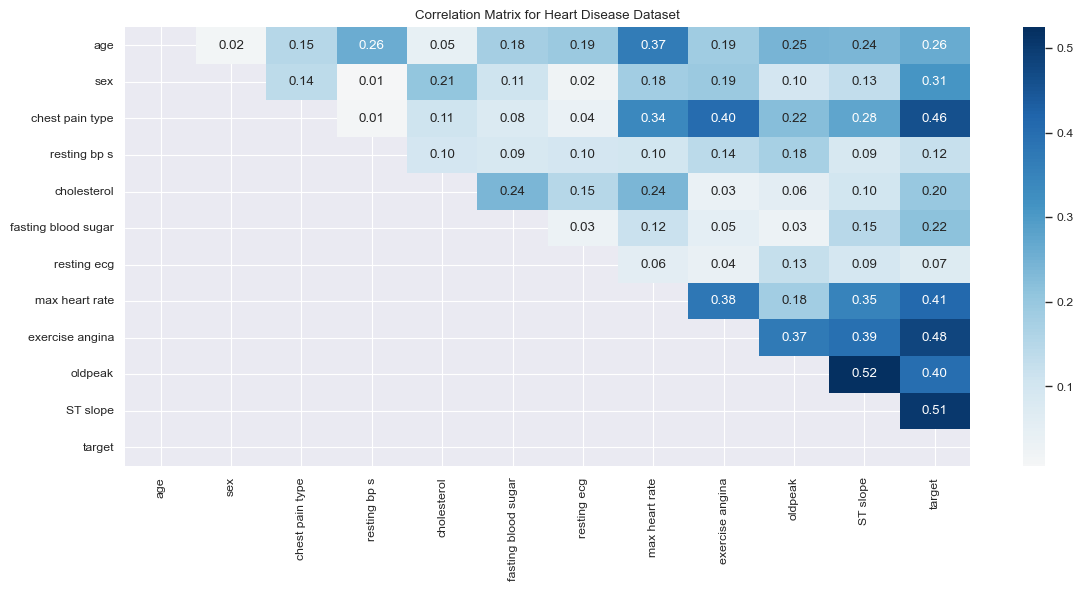

In [10]:
plt.figure(figsize=(12,6))
corr_mat = data.corr().abs()
mask = np.tril(np.ones_like(corr_mat,dtype=bool))
sns.heatmap(corr_mat, mask=mask, annot=True, cmap='RdBu', center=0, fmt='.2f')
plt.title('Correlation Matrix for Heart Disease Dataset')
plt.tight_layout()
plt.savefig('../results/correlation_matrix.png', dpi=300)
plt.show()

Drop highly correlated features if exist

In [11]:
upper_tri = corr_mat.where(np.triu(np.ones(corr_mat.shape),k=1).astype(bool))
to_drop = [col for col in upper_tri.columns if any(upper_tri[col] > 0.7)]
print(f'Features to drop due to high correlation: {to_drop}')

Features to drop due to high correlation: []


# 3. spliting the data


In [12]:
X = data.drop('target',axis=1)
y = data['target']

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42,stratify=y)

# 4. train and evaluate baseline KNN model

In [17]:
def train_evaluate_knn(X_train,X_test,y_train,y_test ,scaling=False, **kwargs):
    if scaling:
        scaler = StandardScaler()
        X_train_scaled= scaler.fit_transform(X_train)
        X_test_scaled= scaler.transform(X_test)
        print("\nRunning KNN with scaling.")
        X_train_use ,X_test_use = X_train_scaled, X_test_scaled
    else:
        print("\nRunning KNN without scaling.")
        X_train_use ,X_test_use = X_train, X_test

    knn_model = KNeighborsClassifier(**kwargs)
    knn_model.fit(X_train_use,y_train)
    y_pred = knn_model.predict(X_test_use)

    acc = accuracy_score(y_test,y_pred)
    f1 = f1_score(y_test,y_pred)

    cv_acc = cross_val_score(knn_model,X_train_use, y_train, cv=5, scoring='accuracy').mean()
    cv_f1 = cross_val_score(knn_model,X_train_use, y_train, cv=5, scoring='f1').mean()


    clr = classification_report(y_test,y_pred)
    cm = confusion_matrix(y_test,y_pred)

    print(f"\nAccuracy (Test): {acc:.4f} | CV: {cv_acc:.4f}")
    print(f"F1-Score (Test): {f1:.4f} | CV: {cv_f1:.4f}")

    print("\nConfusion Matrix:\n", cm)
    print("\nClassification Report:\n", clr)

    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap='Blues')
    plt.title(f'Confusion Matrix -KNN {'Scaled' if scaling else 'Unscaled'}')
    plt.savefig(f'../results/cm_KNN_{'Scaled' if scaling else 'Unscaled'}.png')
    return{
        'model':knn_model,
        'scaler':scaler if scaling else None,
        'X_train_use':X_train_use,
        'X_test_use':X_test_use,
        'Accuracy':acc,
        'F1':f1,
        'CV_Acc':cv_acc,
        'CV_F1':cv_f1,
        'Confusion_matrix':cm,
        'Classification_report':clr,
    }

****** Results of the Baseline KNN Model ******

Running KNN without scaling.

Accuracy (Test): 0.7017 | CV: 0.7049
F1-Score (Test): 0.7280 | CV: 0.7255

Confusion Matrix:
 [[72 40]
 [31 95]]

Classification Report:
               precision    recall  f1-score   support

           0       0.70      0.64      0.67       112
           1       0.70      0.75      0.73       126

    accuracy                           0.70       238
   macro avg       0.70      0.70      0.70       238
weighted avg       0.70      0.70      0.70       238


Running KNN with scaling.

Accuracy (Test): 0.8361 | CV: 0.8488
F1-Score (Test): 0.8494 | CV: 0.8575

Confusion Matrix:
 [[ 89  23]
 [ 16 110]]

Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.79      0.82       112
           1       0.83      0.87      0.85       126

    accuracy                           0.84       238
   macro avg       0.84      0.83      0.83       238
weighted avg  

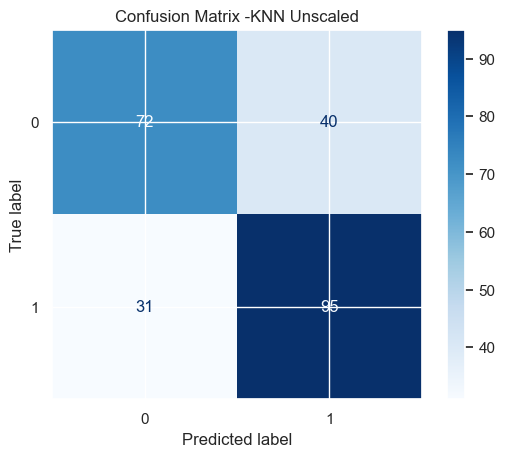

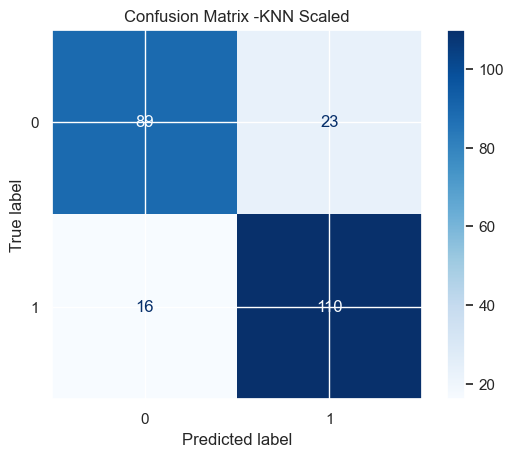

In [18]:
print("****** Results of the Baseline KNN Model ******")
result_unscaled = train_evaluate_knn(X_train,X_test,y_train,y_test,scaling=False)
result_scaled = train_evaluate_knn(X_train,X_test,y_train,y_test,scaling=True)

# 5. OOA Implementation (adapted from Octopus Optimization Algorithm article)
### Levy Flight helper (Eq. 13-14 from article)

In [19]:
def levy_flight(dim, beta=1.5):
    numerator = gamma(1 + beta) * np.sin(np.pi * beta /2)
    denomenator = gamma((1 + beta) /2) * beta * (2 ** ((beta-1) /2))
    sigma = (numerator / denomenator) ** (1/beta)
    u = np.random.normal(0, 1, dim)
    v = np.random.normal(0,1, dim)
    step = 0.01 * u * sigma/ (np.abs(v) ** (1/beta))

    return step

In [25]:
def ooa_optimize(obj_func, lb, ub, dim=2, N=30, max_iter=80, Nh=20, Ns=10):
    np.random.seed(42)
    pop = np.random.uniform(lb,ub,(N,dim))
    fitness = np.array([obj_func(ind) for ind in pop])
    best_idx = np.argmin(fitness)
    best_pos = pop[best_idx].copy()
    best_fit = fitness[best_idx]
    history = [-best_fit]

    vr , ll = 3, 0.8

    for t in range(1,max_iter +1):
        for i in range(Nh):
            trans = (2 * np.random.rand() -1) * vr * (1-t / max_iter)
            if abs(trans) < ll:
                new_pos = pop[i] + np.random.rand() * (best_pos - pop[i]) * levy_flight(dim)
                new_pos = np.clip(new_pos,lb,ub)
                new_fit = obj_func(new_pos)
                if new_fit < fitness[i]:
                    pop[i] = new_pos
                    fitness[i] = new_fit
                    if new_fit < best_fit:
                        best_pos, best_fit = new_pos,new_fit
        
        for i in range(Nh, N):
            new_pos = pop[i] + (2 * np.random.rand(dim) - 1) * (ub - lb)  * (1-t / max_iter)
            new_pos = np.clip(new_pos, lb, ub)
            new_fit = obj_func(new_pos)
            if new_fit < fitness[i]:
                pop[i] = new_pos
                fitness[i] = new_fit
                if new_fit < best_fit:
                    best_pos, best_fit = new_pos, new_fit
        
        history.append(-best_fit)
        
        if t%20 ==0:
            print(f"Iter {t}: Best CV Acc ={-best_fit:.4f}")

    plt.figure(figsize=(8,5))
    plt.plot(history)
    plt.xlabel('Iterations')
    plt.ylabel('Fitness')
    plt.title(f'Fitness Evaluation during {max_iter} iterations')
    plt.savefig('../results/fitness_evaluation.png', dpi=300)
    plt.show()

    return best_pos , -best_fit

In [26]:
scaler_ooa = StandardScaler()
X_train_scaled = scaler_ooa.fit_transform(X_train)
X_test_scaled = scaler_ooa.transform(X_test)

In [27]:
# objective function

def knn_objective(params):
    k = int(np.clip(params[0],2,30))  
    p = np.clip(params[1],1,3)
    knn =KNeighborsClassifier(n_neighbors=k, p=p, metric='minkowski')
    
    #cv on train for robust opt
    cv_acc = cross_val_score(knn,X_train_scaled,y_train,cv=5, scoring='accuracy').mean()

    return -(cv_acc) # min -cv acc


**** OOA Optimazation (CV based) ****
Iter 20: Best CV Acc =0.8603
Iter 40: Best CV Acc =0.8603
Iter 60: Best CV Acc =0.8614
Iter 80: Best CV Acc =0.8624


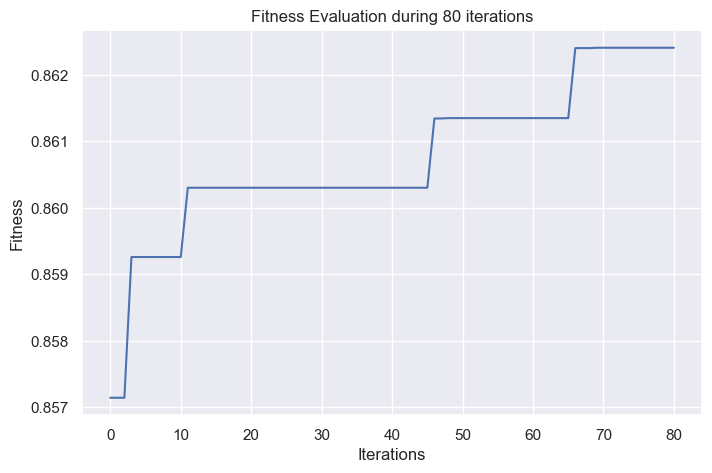


Best OOA Params : k=7, p=1.36
Best OOA CV Accuracy:0.8624


In [30]:
lb = np.array([1,1])
ub = np.array([30,3])
dim = 2 

print("\n**** OOA Optimazation (CV based) ****")
best_params, best_cv_acc = ooa_optimize(knn_objective,lb,ub,dim,N=30,max_iter=80)
best_k, best_p = int(best_params[0]),best_params[1]

print(f"\nBest OOA Params : k={best_k}, p={best_p:.2f}")
print(f"Best OOA CV Accuracy:{best_cv_acc:.4f}")

In [31]:
# eval tuned on test 

knn_opt = KNeighborsClassifier(n_neighbors=best_k, p=best_p, metric='minkowski')
knn_opt.fit(X_train_scaled,y_train)
y_pred_opt = knn_opt.predict(X_test_scaled)

acc_opt = accuracy_score(y_test,y_pred_opt)
f1_opt = f1_score(y_test,y_pred_opt)
cv_acc_opt = cross_val_score(knn_opt,X_train_scaled,y_train,cv=5,scoring='accuracy').mean()
cv_f1_opt = cross_val_score(knn_opt,X_train_scaled,y_train,cv=5,scoring='f1').mean()

cm_opt = confusion_matrix(y_test, y_pred_opt)
clr_opt = classification_report(y_test, y_pred_opt)

In [32]:
#overfit checker
train_acc = accuracy_score(y_train,knn_opt.predict(X_train_scaled))
print(f"Overfit checker : Train acc={train_acc:.4f}  vs Test= {acc_opt:.4f} (Diff < 0.05 -->ok)")

Overfit checker : Train acc=0.8908  vs Test= 0.8529 (Diff < 0.05 -->ok)


In [33]:
print(f"\nOOA-KNN Test Acc:{acc_opt:.4f} | CV-acc: {cv_acc_opt:.4f}")
print(f"OOA-KNN Test F1:{acc_opt:.4f} | CV-f1: {cv_f1_opt:.4f}")


OOA-KNN Test Acc:0.8529 | CV-acc: 0.8624
OOA-KNN Test F1:0.8529 | CV-f1: 0.8690


In [34]:
print("\nOOA Confusion Matrix:\n", cm_opt)
print("\nOOA Classification Report:\n", clr_opt)


OOA Confusion Matrix:
 [[ 90  22]
 [ 13 113]]

OOA Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.80      0.84       112
           1       0.84      0.90      0.87       126

    accuracy                           0.85       238
   macro avg       0.86      0.85      0.85       238
weighted avg       0.85      0.85      0.85       238



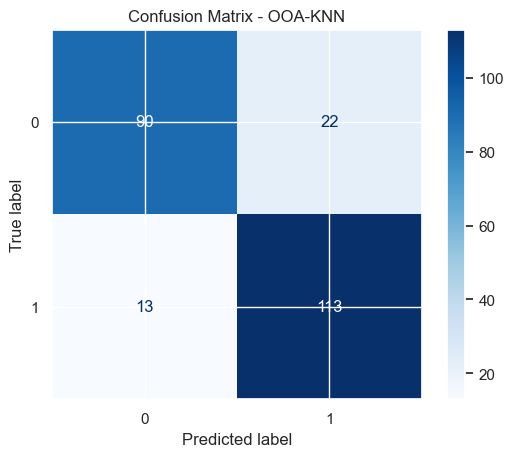

In [35]:
disp_opt = ConfusionMatrixDisplay(confusion_matrix=cm_opt)
disp_opt.plot(cmap='Blues')
plt.title('Confusion Matrix - OOA-KNN')
plt.savefig('../results/cm_ooa_knn.png')
plt.show()

In [36]:
#comparision table 
print("\n***** Performance Comparision ****")
comparison_data={
    'Model':['KNN Unscaled (Default)','KNN Scaled (Default)','OOA-KNN (Tuned)'],
    'Test Acc' : [result_unscaled['Accuracy'],result_scaled['Accuracy'],acc_opt],
    'Test F1' : [result_unscaled['F1'],result_scaled['F1'],f1_opt],
    'CV Acc' : [result_unscaled['CV_Acc'],result_scaled['CV_Acc'],cv_acc_opt],
    'CV F1' : [result_unscaled['CV_F1'],result_scaled['CV_F1'],cv_f1_opt],
}
comparision = pd.DataFrame(comparison_data)
print(comparision.round(4))


***** Performance Comparision ****
                    Model  Test Acc  Test F1  CV Acc   CV F1
0  KNN Unscaled (Default)    0.7017   0.7280  0.7049  0.7255
1    KNN Scaled (Default)    0.8361   0.8494  0.8488  0.8575
2         OOA-KNN (Tuned)    0.8529   0.8659  0.8624  0.8690


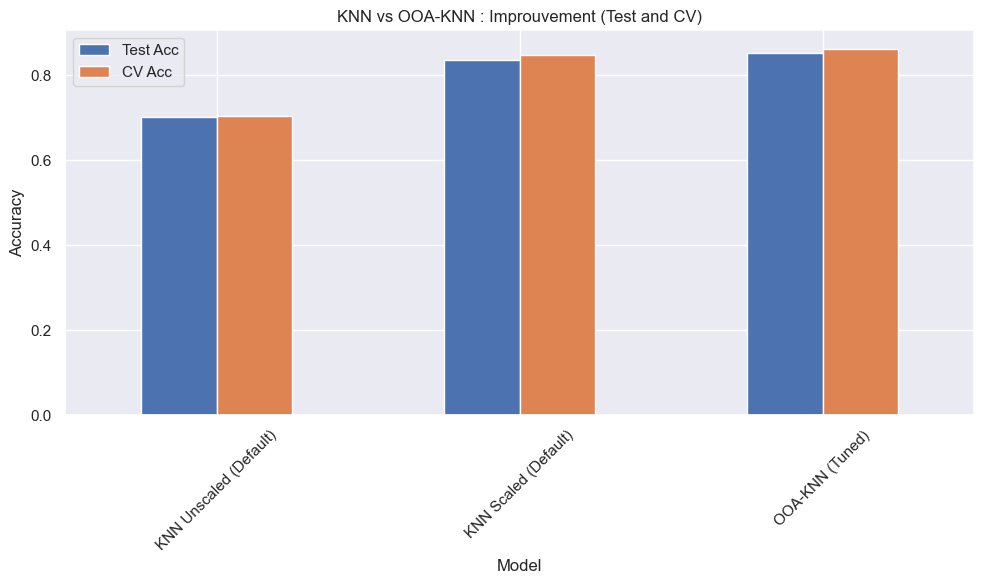

In [37]:
#viz the comparition
comparision.set_index('Model')[['Test Acc','CV Acc']].plot(kind='bar',figsize=(10,6))
plt.title('KNN vs OOA-KNN : Improuvement (Test and CV)')
plt.ylabel('Accuracy')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.savefig('../results/performance_comparision.png')
plt.show()
